In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf

print(f"TensorFlow Version: {tf.__version__}")
tf.random.set_seed(42)

# Các hằng số
ORIGINAL_NUM_CLASSES = 43  # Tổng số lớp ban đầu trên disk
allowed_labels = {14, 33, 34, 35}  # Các nhãn bạn muốn train và test
label_map = {14: 0, 33: 1, 34: 2, 35: 3}  # Ánh xạ từ nhãn gốc sang nhãn mới
NUM_CLASSES = len(allowed_labels)
IMG_SIZE = (30, 30)
cur_path = Path.cwd()

# Load training data với các nhãn được phép
data = []
labels = []

for i in range(ORIGINAL_NUM_CLASSES):
    if i not in allowed_labels:
        continue  # Bỏ qua các lớp không nằm trong allowed_labels

    folder_path = cur_path / 'train' / str(i)
    if not folder_path.exists():
        print(f"Folder {folder_path} not found!")
        continue

    for img_name in os.listdir(folder_path):
        try:
            image = Image.open(folder_path / img_name)
            image = image.resize(IMG_SIZE)
            data.append(np.array(image))
            # Sử dụng ánh xạ để chuyển nhãn gốc sang nhãn mới (0 tới 5)
            labels.append(label_map[i])
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

# Chuyển đổi sang numpy array
data = np.array(data)
labels = np.array(labels)
print("Training data shape:", data.shape)
print("Training labels shape:", labels.shape)


TensorFlow Version: 2.18.0
Training data shape: (3089, 30, 30, 3)
Training labels shape: (3089,)


In [2]:

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2)

# One-hot encode các nhãn
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

# Normalize ảnh
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Xây dựng model (sử dụng Input layer theo khuyến nghị của TF2)
model = tf.keras.Sequential([
    tf.keras.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_val, y_val)
)



Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5387 - loss: 1.0178 - val_accuracy: 0.9434 - val_loss: 0.1618
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9676 - loss: 0.1203 - val_accuracy: 0.9984 - val_loss: 0.0174
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9882 - loss: 0.0376 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9969 - loss: 0.0193 - val_accuracy: 0.9984 - val_loss: 0.0135
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9896 - loss: 0.0340 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9989 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9957 - loss: 0.0303 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9986 - loss: 0.0080 - val_accuracy: 0.9984 - v

In [2]:
# Lưu model
saved_model_name = "traffic_detect_4_classes.keras"

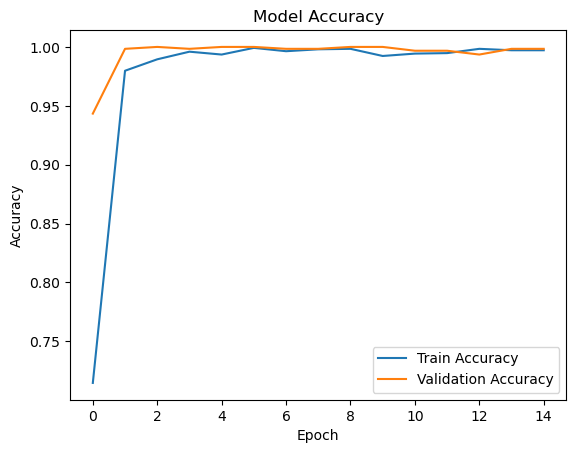

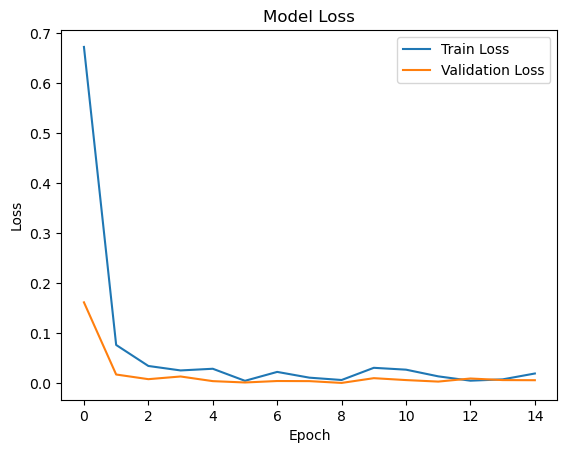

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test Accuracy: 99.80%


In [ ]:

model.save(saved_model_name)

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ---------------------
# Xử lý dữ liệu test
# Đọc file CSV test
test_df = pd.read_csv('Test.csv')
# Lọc những dòng có nhãn thuộc allowed_labels
test_df = test_df[test_df["ClassId"].isin(allowed_labels)]
true_labels = test_df["ClassId"].values
# Áp dụng ánh xạ cho nhãn test
true_labels_mapped = [label_map[int(lbl)] for lbl in true_labels]
image_paths = test_df["Path"].values

test_data = []
for img_path in image_paths:
    try:
        image = Image.open(img_path)
        image = image.resize(IMG_SIZE)
        test_data.append(np.array(image))
    except Exception as e:
        print(f"Error loading test image {img_path}: {e}")

X_test = np.array(test_data).astype('float32') / 255.0

# Dự đoán và đánh giá
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(true_labels_mapped, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [4]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf

# Load model đã được lưu
model = tf.keras.models.load_model(saved_model_name)

# Định nghĩa dictionary cho nhãn
classes = {       
    0: 'Stop',             
    1: 'Turn right ahead',     
    2: 'Turn left ahead',       
    3: 'Ahead only' 
}

# Khởi tạo camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Không thể mở camera!")
    exit()

def detect_and_crop_circular_sign(frame):
    """
    Phát hiện và cắt vùng biển báo hình tròn từ khung hình.
    Trả về: Ảnh cắt (30x30) hoặc None nếu không tìm thấy biển báo.
    """
    # Chuyển sang grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Làm mờ để giảm nhiễu
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Phát hiện hình tròn bằng Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=50,  # Khoảng cách tối thiểu giữa các tâm hình tròn
        param1=50,   # Ngưỡng phát hiện cạnh
        param2=30,   # Ngưỡng xác nhận hình tròn
        minRadius=10,  # Bán kính tối thiểu
        maxRadius=100  # Bán kính tối đa
    )
    
    if circles is not None:
        # Lấy hình tròn đầu tiên (giả định chỉ có một biển báo)
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]
        
        # Cắt vùng quanh tâm hình tròn
        # Mở rộng vùng cắt để bao gồm toàn bộ biển báo
        margin = int(r * 1.2)  # Mở rộng 20% bán kính
        x_min = max(x - margin, 0)
        x_max = min(x + margin, frame.shape[1])
        y_min = max(y - margin, 0)
        y_max = min(y + margin, frame.shape[0])
        
        # Cắt vùng ảnh
        cropped = frame[y_min:y_max, x_min:x_max]
        
        # Resize về 30x30 để khớp với mô hình
        cropped_pil = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        cropped_resized = cropped_pil.resize((30, 30))
        
        return np.array(cropped_resized), (x, y, r)
    return None, None

while True:
    ret, frame = cap.read()
    if not ret:
        print("Không nhận được frame từ camera")
        break

    # Phát hiện và cắt biển báo
    cropped_sign, circle_info = detect_and_crop_circular_sign(frame)
    
    if cropped_sign is not None:
        # Chuẩn bị ảnh cắt để dự đoán
        img_array = cropped_sign.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Dự đoán với model
        predictions = model.predict(img_array)
        predicted_label = int(np.argmax(predictions, axis=1)[0])
        label_text = classes.get(predicted_label, "Unknown")
        
        # Vẽ hình tròn lên frame để kiểm tra trực quan
        if circle_info is not None:
            x, y, r = circle_info
            cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
    else:
        label_text = "No sign detected"
    
    # In nhãn ra console
    print("Detected:", label_text)
    
    # Hiển thị nhãn trên frame camera
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Hiển thị khung hình
    cv2.imshow("Camera", frame)
    
    # Nhấn 'q' để thoát
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Giải phóng camera và đóng cửa sổ hiển thị
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Detected: Ahead only
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Detected: Ahead o

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import cv2

# 4. Load model và chuyển đổi sang TensorFlow Lite
loaded_model = tf.keras.models.load_model(saved_model_name)
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Lưu file TensorFlow Lite
saved_tflite_model_name = "traffic_detect_4_classes.tflite"
with open(saved_tflite_model_name, "wb") as f:
    f.write(tflite_model)
print("Đã chuyển đổi và lưu model thành traffic_detect_4_classes.tflite")

### 7. Sử dụng camera với TensorFlow Lite
classes = {0: 'Stop', 1: 'Turn Right Ahead', 2: 'Turn Left Ahead', 3: 'Straight Only'}

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera!")
    exit()

# Load TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=saved_tflite_model_name)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Hàm phát hiện và cắt biển báo hình tròn
def detect_and_crop_circular_sign(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    circles = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
        param1=50, param2=30, minRadius=10, maxRadius=100
    )
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]
        margin = int(r * 1.2)
        x_min = max(x - margin, 0)
        x_max = min(x + margin, frame.shape[1])
        y_min = max(y - margin, 0)
        y_max = min(y + margin, frame.shape[0])
        cropped = frame[y_min:y_max, x_min:x_max]
        cropped_pil = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        cropped_resized = cropped_pil.resize((30, 30))
        return np.array(cropped_resized), (x, y, r)
    return None, None

# Vòng lặp xử lý camera
while True:
    
    ret, frame = cap.read()
    if not ret:
        print("No frame received from camera")
        break

    cropped_sign, circle_info = detect_and_crop_circular_sign(frame)
    if cropped_sign is not None:
        img_array = cropped_sign.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Dự đoán với TensorFlow Lite
        interpreter.set_tensor(input_details[0]['index'], img_array)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = int(np.argmax(output_data, axis=1)[0])
        label_text = classes.get(predicted_label, "Unknown")
        
        if circle_info is not None:
            x, y, r = circle_info
            cv2.circle(frame, (x, y), r, (0, 255, 0), 2)
    else:
        label_text = "No sign detected"

    print("Detected:", label_text)
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow("Camera", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

INFO:tensorflow:Assets written to: C:\Users\nguye\AppData\Local\Temp\tmp7g7z_2zm\assets


INFO:tensorflow:Assets written to: C:\Users\nguye\AppData\Local\Temp\tmp7g7z_2zm\assets


Saved artifact at 'C:\Users\nguye\AppData\Local\Temp\tmp7g7z_2zm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 30, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2746610055856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610043712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746609937120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610860800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610875408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610872416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610873120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610977600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610989040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2746610989744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  27466134